In [42]:
import pathlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as sci_opt
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from pyopt.client import PriceHistory
pd.set_option('display.max_colwidth', -1)
pd.set_option('expand_frame_repr', False)

C:\Users\abcd\AppData\Local\Temp\ipykernel_8792\1094341640.py:11: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [25]:
#Define the symbols
symbols=['AAPL','MSFT','SQ']
#Grab the number of stocks in our portfolio
number_of_symbols=len(symbols)
#Loading the Data
price_data_frame: pd.DataFrame = pd.read_csv('stock_data.csv')

#Print the head.
price_data_frame

,date,close,volume,open,high,low,symbol
0,2020-07-23,122.93,11010220,127.740,129.8494,121.3200,SQ
1,2020-07-22,129.18,8437494,127.490,131.7100,127.0600,SQ
2,2020-07-21,126.99,10787520,129.950,130.8000,125.0700,SQ
3,2020-07-20,128.39,12423990,121.260,129.4600,120.5300,SQ
4,2020-07-17,120.73,6968161,120.980,122.3800,118.5900,SQ
...,...,...,...,...,...,...,...
373,2020-01-30,323.87,31685810,320.544,324.0900,318.7500,AAPL
374,2020-01-29,324.34,54149930,324.450,327.8500,321.3800,AAPL
375,2020-01-28,317.69,40558490,312.600,318.4000,312.1900,AAPL
376,2020-01-27,308.95,40485010,310.060,311.7700,304.8800,AAPL


In [26]:
#Grab the columns we need
price_data_frame=price_data_frame[['date','symbol','close']]
#Print the Data Frame to make the Symbols the headers
price_data_frame=price_data_frame.pivot(
    index='date',
    columns='symbol',
    values='close'
)
price_data_frame

symbol,AAPL,MSFT,SQ
date,,,
2020-01-24,318.31,165.04,71.14
2020-01-27,308.95,162.28,71.05
2020-01-28,317.69,165.46,74.80
2020-01-29,324.34,168.04,76.16
2020-01-30,323.87,172.78,76.10
...,...,...,...
2020-07-17,385.31,202.88,120.73
2020-07-20,393.43,211.60,128.39
2020-07-21,388.00,208.75,126.99


In [32]:
#Calculate the Log of returns.
log_return = np.log(1 + price_data_frame.pct_change())
#Generate Random Weights.
random_weights = np.array(np.random.random(number_of_symbols))
#Generate the Rebalance Weights, these should equal 1.
rebalance_weights = random_weights / np.sum(random_weights)
#Calculate the Expected Returns, annualize it by multiplying it by `252`.
exp_ret = np.sum((log_return.mean() * rebalance_weights) * 252)
#Calculate the expected volatality
exp_vol=np.sqrt(
    np.dot(
        rebalance_weights.T,
        np.dot(
            log_return.cov()*252,
           rebalance_weights
        )
    )
)
#Calculate the Sharpe Ratio.
sharpe_ratio = exp_ret / exp_vol

#Put the weights into a data frame to see them better.
weights_df = pd.DataFrame(data={
'random_weights': random_weights,
'rebalance_weights': rebalance_weights
})
print('')
print('='*80)
print('PORTFOLIO WEIGHTS:')
print('-'*80)
print(weights_df)
print('-'*80)

#Do the same with the other metrics.
metrics_df = pd.DataFrame(data={
    'Expected Portfolio Returns': exp_ret,
    'Expected Portfolio Volatility': exp_vol,
    'Portfolio Sharpe Ratio': sharpe_ratio
}, index=[0])

print('')
print('='*80)
print('PORTFOLIO METRICS:')
print('-'*80)
print(metrics_df)
print('-'*80)


PORTFOLIO WEIGHTS:
--------------------------------------------------------------------------------
   random_weights  rebalance_weights
0  0.660992        0.521943         
1  0.232741        0.183781         
2  0.372674        0.294276         
--------------------------------------------------------------------------------

PORTFOLIO METRICS:
--------------------------------------------------------------------------------
   Expected Portfolio Returns  Expected Portfolio Volatility  Portfolio Sharpe Ratio
0  0.562608                    0.597317                       0.941892              
--------------------------------------------------------------------------------


In [37]:
#Initialize the components, to run a Monte Carlo Simulation.

#We will run 5000 iterations.
num_of_portfolios = 10000

#Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

#Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

#Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

#Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

#Start the simulations.
for ind in range(num_of_portfolios):

    #First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    #Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    #Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_return.mean() * weights) * 252)

    #Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    #Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

#Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio
simulations_data = [ret_arr, vol_arr, sharpe_arr, all_weights]

#Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

#Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

#Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

#Print out the results.
print('')
print('='*80)
print('SIMULATIONS RESULT:')
print('-'*80)
print(simulations_df.head())
print('-'*80)


SIMULATIONS RESULT:
--------------------------------------------------------------------------------
    Returns  Volatility  Sharpe Ratio                                                 Portfolio Weights
0  0.798271  0.709962    1.124384      [0.019507036534227418, 0.4188469831332891, 0.5616459803324835]  
1  0.350695  0.533780    0.657003      [0.6290204064762401, 0.36804859482231567, 0.0029309987014442384]
2  0.680582  0.647036    1.051844      [0.19984912417371534, 0.38245310011438155, 0.41769777571190314] 
3  0.444487  0.555124    0.800697      [0.5925975505364165, 0.27390346452299025, 0.13349898494059328]  
4  0.640021  0.627182    1.020471      [0.23417538459363926, 0.40184743575350684, 0.3639771796528539]  
--------------------------------------------------------------------------------


In [38]:
#Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]

#Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]

print('')
print('='*80)
print('MAX SHARPE RATIO:')
print('-'*80)
print(max_sharpe_ratio)
print('-'*80)

print('')
print('='*80)
print('MIN VOLATILITY:')
print('-'*80)
print(min_volatility)
print('-'*80)


MAX SHARPE RATIO:
--------------------------------------------------------------------------------
Returns              1.095194                                                        
Volatility           0.911203                                                        
Sharpe Ratio         1.201921                                                        
Portfolio Weights    [0.007511380245901808, 0.002233281159018373, 0.9902553385950799]
Name: 1050, dtype: object
--------------------------------------------------------------------------------

MIN VOLATILITY:
--------------------------------------------------------------------------------
Returns              0.334481                                                       
Volatility           0.532975                                                       
Sharpe Ratio         0.627573                                                       
Portfolio Weights    [0.7735104553069071, 0.2257173256148452, 0.0007722190782477018]
Name: 4957,

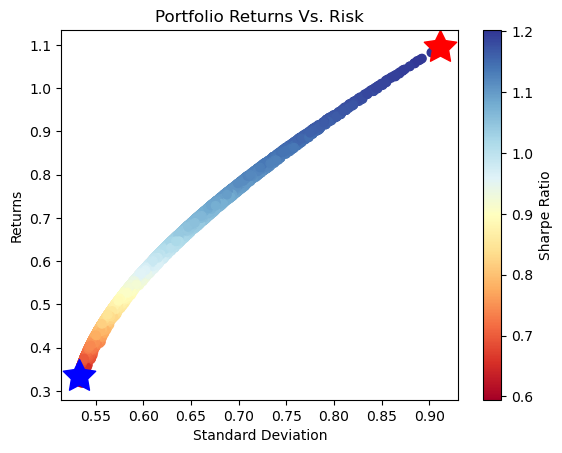

In [39]:
#This is so I can see the plot inside of my Jupyter Notebook.
%matplotlib inline

#Plot the data on a Scatter plot.
plt.scatter(
    y=simulations_df['Returns'],
    x=simulations_df['Volatility'],
    c=simulations_df['Sharpe Ratio'],
    cmap='RdYlBu'
)

#Give the Plot some labels, and titles.
plt.title('Portfolio Returns Vs. Risk')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')

#Plot the Max Sharpe Ratio, using a `Red Star`.
plt.scatter(
    max_sharpe_ratio[1],
    max_sharpe_ratio[0],
    marker=(5, 1, 0),
    color='r',
    s=600
)

#Plot the Min Volatility, using a `Blue Star`.
plt.scatter(
    min_volatility[1],
    min_volatility[0],
    marker=(5, 1, 0),
    color='b',
    s=600
)

#Finally, show the plot.
plt.show()

In [40]:
def get_metrics(weights: list) -> np.array:

    #Convert to a Numpy Array.
    weights = np.array(weights)

    #Calculate the returns, remember to annualize them (252).
    ret = np.sum(log_return.mean() * weights) * 252

    #Calculate the volatility, remember to annualize them (252).
    vol = np.sqrt(
        np.dot(weights.T, np.dot(log_return.cov() * 252, weights))
    )

    #Calculate the Sharpe Ratio.
    sr = ret / vol

    return np.array([ret, vol, sr])

def grab_negative_sharpe(weights: list) -> np.array:
    return get_metrics(weights)[2] - 1

def grab_volatility(weights: list) -> np.array:
    return get_metrics(weights)[1]

def check_sum(weights: list) -> float:
    return np.sum(weights) - 1

In [43]:
#Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

#Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

#We need to create an initial guess to start with,
#and usually the best initial guess is just an
#even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

#Perform the operation to minimize the risk.
optimized_sharpe = sci_opt.minimize(
    grab_negative_sharpe, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

#Print the results.
print('')
print('='*80)
print('OPTIMIZED SHARPE RATIO:')
print('-'*80)
print(optimized_sharpe)
print('-'*80)


OPTIMIZED SHARPE RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -0.41952441797980555
       x: [ 1.000e+00  0.000e+00  8.674e-15]
     nit: 4
     jac: [ 7.451e-09  2.132e-01  1.381e+00]
    nfev: 16
    njev: 4
--------------------------------------------------------------------------------


In [44]:
#Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_sharpe.x)

#Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_sharpe.x)
print('-'*80)


#Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[1.00000000e+00 0.00000000e+00 8.67361738e-15]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.31086729 0.53553897 0.58047558]
--------------------------------------------------------------------------------


In [45]:
#Define the boundaries for each symbol. Remember I can only invest up to 100% of my capital into a single asset.
bounds = tuple((0, 1) for symbol in range(number_of_symbols))

#Define the constraints, here I'm saying that the sum of each weight must not exceed 100%.
constraints = ({'type': 'eq', 'fun': check_sum})

#We need to create an initial guess to start with,
#and usually the best initial guess is just an
#even distribution. In this case 25% for each of the 4 stocks.
init_guess = number_of_symbols * [1 / number_of_symbols]

# Perform the operation to minimize the risk.
optimized_volatility = sci_opt.minimize(
    grab_volatility, # minimize this.
    init_guess, # Start with these values.
    method='SLSQP',
    bounds=bounds, # don't exceed these bounds.
    constraints=constraints # make sure you don't exceed the 100% constraint.
)

#Print the results.
print('')
print('='*80)
print('OPTIMIZED VOLATILITY RATIO:')
print('-'*80)
print(optimized_volatility)
print('-'*80)


OPTIMIZED VOLATILITY RATIO:
--------------------------------------------------------------------------------
 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.5328609543040769
       x: [ 7.485e-01  2.515e-01  3.469e-17]
     nit: 6
     jac: [ 5.329e-01  5.328e-01  6.439e-01]
    nfev: 24
    njev: 6
--------------------------------------------------------------------------------


In [46]:
#Grab the metrics.
optimized_metrics = get_metrics(weights=optimized_volatility.x)

#Print the Optimized Weights.
print('')
print('='*80)
print('OPTIMIZED WEIGHTS:')
print('-'*80)
print(optimized_volatility.x)
print('-'*80)


#Print the Optimized Metrics.
print('')
print('='*80)
print('OPTIMIZED METRICS:')
print('-'*80)
print(optimized_metrics)
print('-'*80)


OPTIMIZED WEIGHTS:
--------------------------------------------------------------------------------
[7.48507673e-01 2.51492327e-01 3.46944695e-17]
--------------------------------------------------------------------------------

OPTIMIZED METRICS:
--------------------------------------------------------------------------------
[0.33649631 0.53286095 0.6314899 ]
--------------------------------------------------------------------------------
